In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## for correlation matrices
import seaborn as sns
%matplotlib inline
## for linear models
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ConfusionMatrix


from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

%config Completer.use_jedi = False
%run ../pyfiles/data_cleaning.py
%run ../pyfiles/unmetDemand.py

In [112]:
np.random.seed(123)

In [113]:
df = pd.read_csv("../data/deepsolar_tract.csv", encoding = "utf-8")


In [114]:
df.set_index(keys = 'fips', inplace = True)

In [115]:
df = drop_redundant_columns(df)

In [116]:
df = create_has_tiles_target_column(df)

In [117]:
df = df.dropna()

In [118]:
X = df.drop('has_tiles', axis = 1)
y = df['has_tiles']

In [122]:
df.shape

(54099, 130)

## Must Run This Before redoing a sampling technique

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

## Sampling Techniques

### Undersampling

In [152]:
rus = RandomUnderSampler()
X_under, y_under = rus.fit_resample(X_train, y_train)

In [153]:
y_under.value_counts()

1    9998
0    9998
Name: has_tiles, dtype: int64

### Oversampling

In [161]:
ros = RandomOverSampler()
X_over, y_over = ros.fit_resample(X_train, y_train)

In [162]:
y_over.value_counts()

1    33281
0    33281
Name: has_tiles, dtype: int64

### SMOTE!

In [169]:
smt = SMOTE()
X_smote, y_smote = smt.fit_sample(X_train, y_train)
print(y_smote.value_counts(),'\n\n', y_test.value_counts())

1    33281
0    33281
Name: has_tiles, dtype: int64 

 1    8320
0    2500
Name: has_tiles, dtype: int64


## SCALE DATA
NOTE: You must change the y_train and X_train to = whatever sampling technique you're using. 

In [170]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_smote)
X_test = scaler.transform(X_test)
y_train = y_smote

In [171]:
parameters = {'penalty':['l1', 'l2'], 'C':[.001, .005, .0005, .0009]}
clf = GridSearchCV(LogisticRegression(solver='saga'), parameters, cv = 5)
clf.fit(X_train, y_train)

C:\Users\BudBe\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\BudBe\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\BudBe\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\BudBe\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\BudBe\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.005, 0.0005, 0.0009],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [172]:
clf.best_params_

{'C': 0.005, 'penalty': 'l2'}

C:\Users\BudBe\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


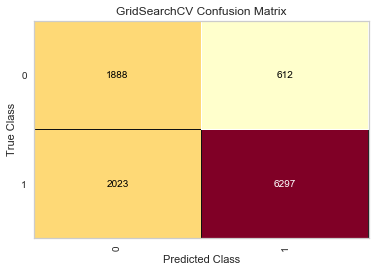

In [173]:
cm = ConfusionMatrix(clf)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()

In [174]:
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.76      0.59      2500
           1       0.91      0.76      0.83      8320

    accuracy                           0.76     10820
   macro avg       0.70      0.76      0.71     10820
weighted avg       0.81      0.76      0.77     10820



# Compare to OZ

In [25]:
falsePositives = isFalsePositive(df, X_test, y_test, best_clf)

In [26]:
buy = isOpportunityZone(falsePositives, scaler = scaler)

In [28]:
buy.shape

(116, 136)

In [ ]:
falsePositives.columns